In [2]:
!pip install eli5

     |████████████████████████████████| 112kB 5.9MB/s eta 0:00:01


In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 104kB/s 


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler
from eli5.sklearn import PermutationImportance
import eli5
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
import torch.optim as optim


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [5]:
pd.set_option('display.max_columns', 500)

Подгружаю датасет и вывожу года присутствующие в датасете

In [6]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', delimiter = ";")

df.order_date = pd.to_datetime(df.order_date)
np.unique([i.year for i in df.order_date])

array([2017])

Сортирую датасет по дате

In [7]:
df = df.sort_values('order_date')

In [8]:
np.unique([i.month for i in df.order_date])

array([6, 7, 8, 9])

In [9]:
df = df.drop_duplicates()

In [10]:
len(np.unique(df.order_id))

42857

In [11]:
unique = np.unique(df.order_id, return_counts=True)
unique[0][np.argwhere(unique[1] > 1)][-1]

array([840280])

In [12]:
df[df.order_id == 840280]

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
2728,99419.82,9,0.0,235010.7,0,0.0,27,0,42,10000.0,10000,14,0.0,2017-09-25,0.0,840280,393177,1
2729,99419.82,9,0.0,257509.8,0,0.0,27,0,42,10000.0,10000,14,0.0,2017-09-25,0.0,840280,393177,1


Убираем строчки одинаковые по 'order_id', так как остались записи с одинаковыми 'order_id', но строчки несильно различаются (как видно из верхнего примера)

In [13]:
df.drop_duplicates(subset = 'order_id', keep = 'first', inplace = True)

Проверка на пустые значения

In [14]:
df.isna().mean()[df.isna().mean() > 0]

first_loan    0.000397
dtype: float64

Пустые значения 'first_loan' заменяем значениями из столбца 'loan_cost_all'

In [15]:
df.first_loan.fillna(df.loan_cost_all, inplace = True)

In [16]:
df[df.cost_all>0].expert.value_counts()

0    8381
Name: expert, dtype: int64

Добавляю новый признак, который отвечает за то, на какой по счёту день подана заявка, начиная от самой первой заявки в исходном датасете.

In [17]:
min_date = min(df.order_date)
df['days_since_bg'] = df.apply(lambda x: (x.order_date - min_date).days , axis = 1)

Нижний график отображает пропорцию двух классов в датасете

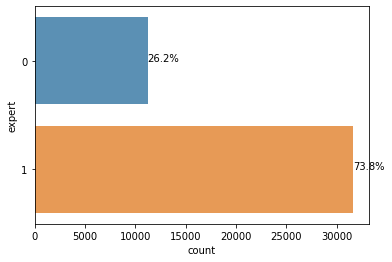

In [18]:
ax = sns.countplot(y="expert", data=df, alpha=0.8)
total = df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.show()

In [19]:
df.dtypes

closed_cred_sum                   float64
closed_creds                        int64
active_cred_sum_overdue           float64
active_cred_sum                   float64
active_cred_day_overdue             int64
active_cred_max_overdue           float64
age                                 int64
gender                              int64
region                              int64
first_loan                        float64
loan_cost_all                       int64
first_days_quant                    int64
month_income                      float64
order_date                 datetime64[ns]
cost_all                          float64
order_id                            int64
client_id                           int64
expert                              int64
days_since_bg                       int64
dtype: object

Новый признак - разница между суммой заявителя и одобренной суммой

In [20]:
df['dif_fl_lca'] = (df.first_loan - df.loan_cost_all)/ 1000 >0

Новый признак, значение true ,если cost_all больше 0 и false, если cost_all равен 0

In [21]:
df['pos_cost_all'] = df.cost_all > 0

Видно из 2 -го и 3 -го графиков, что признаки cost_all и loan_cost_all являются ликовыми(т.е. произошла утечка данных). Это также можно понять даже по их обозначению, тоесть loan_cost_all - одобренная клиенту сумма кредита, cost_all - сумма всех выплат по одобренному кредиту.

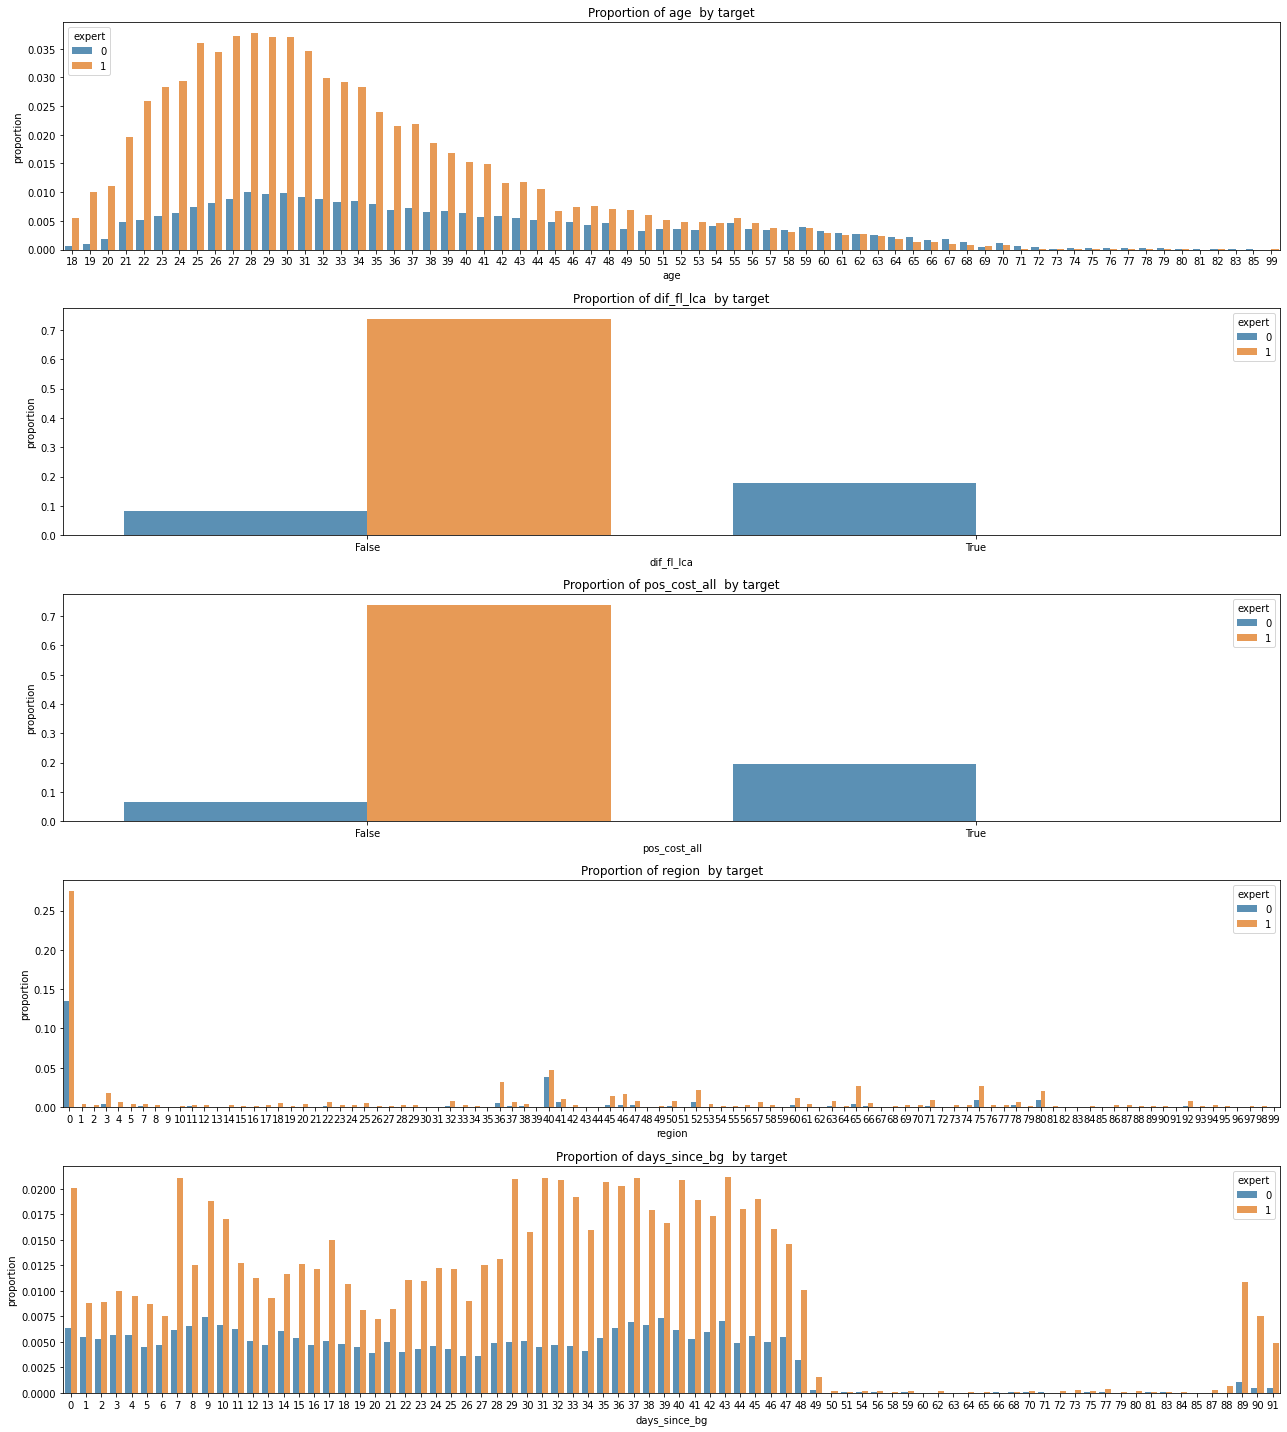

In [22]:
cols_obj = list(['age', 'dif_fl_lca', 'pos_cost_all', 'region', 'days_since_bg'])

#строим графики признаков типа объект от значения таргета, отнормируем на размер датасета
plt.figure(figsize=[18, 20])

i = 1
y, hue = "proportion", "expert"

for f in cols_obj:
    plt.subplot(5, 1, i)
    df[[f, 'expert']]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, "data"), x=f, y='proportion', hue='expert', alpha=0.8)
    plt.title("Proportion of {}  by target".format(f))
    i += 1
plt.tight_layout()
plt.show()

Также исходя из верхних графиков было принято решение добавить две категориальные фичи: 'categorical_days', 'categorical_age'. Первая всего имеет три категории, так как видно, что в течение трёх месяцев примерно есть три паттерна. Аналогично и вторая имеет три категории, связанных уже с возрастом. 

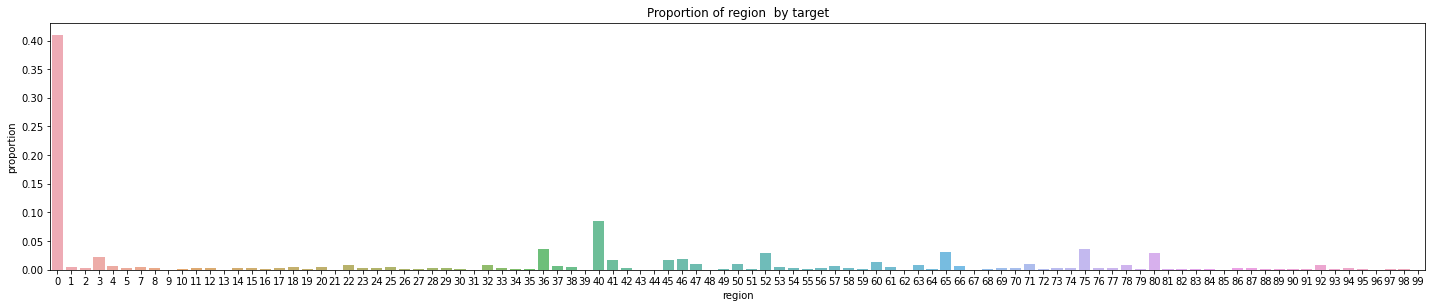

In [23]:
cols_obj = list(['region'])

#строим графики признаков типа объект от значения таргета, отнормируем на размер датасета
plt.figure(figsize=[20, 20])

i = 1
y, hue = "proportion", "expert"

for f in cols_obj:
    plt.subplot(5, 1, i)
    df[[f]]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, "data"), x=f, y='proportion', alpha=0.8)
    plt.title("Proportion of {}  by target".format(f))
    i += 1
plt.tight_layout()
plt.show()

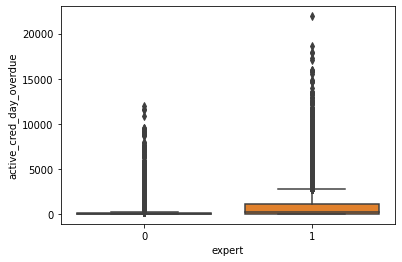

In [24]:
sns.boxplot(x='expert', y='active_cred_day_overdue', data=df)
plt.show()

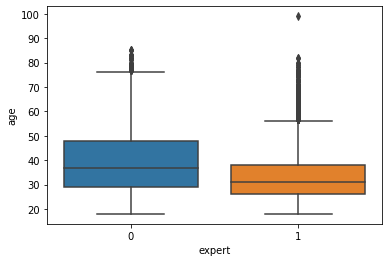

In [25]:
sns.boxplot(x='expert', y='age', data=df)
plt.show()

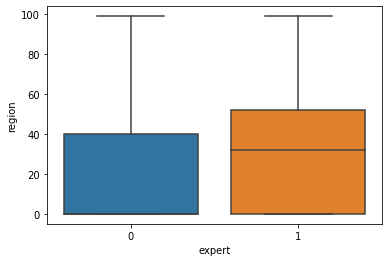

In [26]:
sns.boxplot(x='expert', y='region', data=df)
plt.show()

Дабы точно убедиться, что признаки 'loan_cost_all' и 'cost_all' являются ликовыми, внизу представлен топ важных фичей для логистической регрессии.

In [27]:
validation_ratio = 0.15
test_ratio = 0.10
X_transformed= df.drop(columns = ['client_id', 'expert', 'order_date'], axis = 1)
y = df.expert.replace([0,1], [1, 0])

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size= test_ratio + validation_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= test_ratio/(test_ratio + validation_ratio))

lr = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
lr.fit(X_train, y_train)
perm = PermutationImportance(lr, scoring='f1').fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.tolist())

Weight,Feature
0.5037 ± 0.0091,loan_cost_all
0.3393 ± 0.0076,cost_all
0.3369 ± 0.0068,first_loan
0.0009 ± 0.0011,active_cred_day_overdue
0.0007 ± 0.0006,active_cred_max_overdue
0.0003 ± 0.0000,active_cred_sum_overdue
0 ± 0.0000,pos_cost_all
0 ± 0.0000,gender
0 ± 0.0000,closed_creds
0 ± 0.0000,age


Как говорилось выше, добавляем 'categorical_days' и 'category_age'

In [28]:
def get_days_category(x):
    if x < 49:
        return 1
    elif x < 89:
        return 2
    else:
        return 3

def get_age_category(x):
    if x < 45:
        return 1
    elif x < 54:
        return 2
    else:
        return 3
    
df['categorical_days'] = df.apply(lambda row: get_days_category(row['days_since_bg']), axis=1)
df['category_age'] = df.apply(lambda row: get_age_category(row['age']), axis=1)

Удалим ликовые столбцы и order_id

In [29]:
df = df.drop(columns = ['dif_fl_lca', 'pos_cost_all', 'cost_all', 'loan_cost_all', 'order_id'])
df = df.drop_duplicates()
df = df.reset_index()
df = df.drop(columns = ['index'], axis = 1)

По данным видно, что есть абсолютно идентичные строчки, но при этом значения expert у этих строк различны



In [30]:
grouped_columns =  ['client_id', 'days_since_bg', 'active_cred_sum', 'first_days_quant', 'first_loan', 'month_income']
add_df = df.groupby(by = grouped_columns)
ind_groups = add_df.groups.values()
ind_groups = list(ind_groups)
for i in ind_groups:
    if len(i) > 1:
        print(i)

Int64Index([23984, 23985], dtype='int64')
Int64Index([30446, 30447], dtype='int64')
Int64Index([8059, 8060], dtype='int64')
Int64Index([33158, 33159], dtype='int64')
Int64Index([18591, 18592], dtype='int64')
Int64Index([20796, 20797], dtype='int64')


In [31]:
grouped_columns.append('expert')
add_df = df.groupby(by = grouped_columns)
ind_groups = add_df.groups.values()
ind_groups = list(ind_groups)
for i in ind_groups:
    if len(i) > 1:
        print(i)

В данных есть клиенты, у которых несколько заявок. Чтобы не было ликов (к примеру, смогли бы по сумме всех активных кредитов предсказать одобрена ли была прошлая заявка этого же клиента) последнюю заявку клиента отправляем в тестовую выборку, предпоследнюю заявку в валидационную, а все предыдущие в тренировочную выборку.

In [32]:
grouped_columns =  ['client_id']
ind_groups = df.groupby(by = grouped_columns).groups.values()
ind_groups = list(ind_groups)

In [33]:
train_indices, val_indices, test_indices = [], [], []
all_indices = []
for i in ind_groups:
    if len(i) > 1:
        cur_ind = list(i)
        all_indices.extend(cur_ind)
        if len(i) == 2:
            train_indices.append(cur_ind[0])
            val_indices.append(cur_ind[1])
        else:
            val_indices.append(cur_ind[-2])
            test_indices.append(cur_ind[-1])
            train_indices.extend(cur_ind[:-2])
indices_without_repeated = list(set(range(df.shape[0])) - set(all_indices))

К категориальным признакам применяю one hot encoding, а остальные масштабирую.

In [34]:
scaled_col = ['closed_cred_sum', 'closed_creds', 'active_cred_sum_overdue',\
              'active_cred_sum', 'active_cred_day_overdue', 'active_cred_max_overdue', \
              'age', 'first_loan','first_days_quant', 'month_income']
cat_col = ['gender', 'categorical_days', 'category_age', 'region']

ct = ColumnTransformer([
     ('scaled', StandardScaler(), scaled_col),  
     ('categorical', OneHotEncoder(), cat_col)
])
X = ct.fit_transform(df).toarray()
y = np.array(df.expert.copy())

In [35]:
X_wt_rep = X[indices_without_repeated]
y_wt_rep = y[indices_without_repeated]

Делю данные на train, validation, test таким образом, чтобы все они были стратифицированными.

In [36]:
validation_ratio = 0.15
test_ratio = 0.12
for train_index, test_index in StratifiedShuffleSplit(n_splits= 1, test_size=validation_ratio + test_ratio)\
                                                  .split(X_wt_rep, y_wt_rep):
      X_train, X_test = X[train_index].copy(), X[test_index].copy()
      y_train, y_test = y[train_index].copy(), y[test_index].copy()
      for val_index, test_index in StratifiedShuffleSplit(n_splits= 1,\
                                                  test_size= test_ratio/(test_ratio + validation_ratio))\
                                                  .split(X_test, y_test):
          X_val, X_test = X_test[val_index], X_test[test_index]
          y_val, y_test = y_test[val_index], y_test[test_index]

Добавляю в разделённые выборки клиентов, имеющих несколько заявок в исходных данных. 

In [37]:
X_train = np.append(X_train, X[train_indices], axis = 0)
y_train = np.append(y_train, y[train_indices])
X_val = np.append(X_val, X[val_indices], axis = 0)
y_val = np.append(y_val, y[val_indices])
X_test = np.append(X_test, X[test_indices], axis = 0)
y_test = np.append(y_test, y[test_indices])

После добавление новых элементов, мешаем ряды

In [38]:
perm = np.random.permutation(len(y_train))
X_train, y_train = X_train[perm], y_train[perm]
perm = np.random.permutation(len(y_val))
X_val, y_val = X_val[perm], y_val[perm]
perm = np.random.permutation(len(y_test))
X_test, y_test = X_test[perm], y_test[perm]

In [39]:
X_train.shape

(29985, 117)

In [40]:
X_val.shape

(8038, 117)

In [41]:
X_test.shape

(4748, 117)

### Основной метрикой выбрана F-мера для метки 0, так как нам важно правильно предсказывать одобренные заявки, чтобы банк не нёс убытки и получал прибыль. 

# Logistic Regression

Функция для возвращения таблицы с метриками

In [52]:
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    y_pred = model.predict(X_test)
    report['F1_0'] = f1_score(y_test, y_pred, pos_label= 0)
    report['precision_0'] = precision_score(
        y_test, y_pred, pos_label=0)
    report['precision_1'] = precision_score(
        y_test, y_pred, pos_label=1)
    report['recall_0'] = recall_score(
        y_test, y_pred, pos_label=0)
    report['recall_1'] = recall_score(
        y_test, y_pred, pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

Строю логистическую регрессию, c поиском подходящих гиперпараметров по сетке.

In [ ]:
%%time
lr = LogisticRegression()
f1_0 = make_scorer(f1_score, pos_label = 0)
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
param = {'C': np.linspace(0.001, 10, 10), 'class_weight': ['balanced', None], 'max_iter':[100, 200, 350]}

gs_lr = GridSearchCV(lr, param, scoring= f1_0, cv = sss, verbose = 0)
gs_lr.fit(X_train, y_train)

In [54]:
gs_lr.best_params_

{'C': 7.7780000000000005, 'class_weight': 'balanced', 'max_iter': 100}

In [55]:
y_pred_proba = gs_lr.predict_proba(X_val)[:, 1]
y_pred_lr = gs_lr.predict(X_val)
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_val, y_pred_proba)
df_report['F1_0'] = f1_score(y_val, y_pred_lr, pos_label = 0)
df_report['precision_0'] = precision_score(y_val, y_pred_lr, pos_label=0)
df_report['recall_0'] = recall_score(y_val, y_pred_lr, pos_label=0)
df_report['precision_1'] = precision_score(y_val, y_pred_lr, pos_label=1)
df_report['recall_1'] = recall_score(y_val, y_pred_lr, pos_label=1)

df_report.index = ['LogisticRegression']

In [56]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.78072,0.849802,0.717793


Применим oversampling для 0 класса и обучим логистическую регреессию.

In [57]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'C': np.linspace(0.001, 10, 10), 'class_weight': ['balanced', None], 'max_iter':[100, 300]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
gs_over_samp_lr = GridSearchCV(lr, param, scoring= f1_0, cv = sss)
gs_over_samp_lr.fit(X_over, y_over)

In [59]:
df_report = get_scores(df_report, gs_over_samp_lr, X_val,
                       y_val, 'LogisticRegression_over_samp')

In [60]:
gs_over_samp_lr.best_params_

{'C': 7.7780000000000005, 'class_weight': 'balanced', 'max_iter': 100}

In [61]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756


# Random Forest

Строю random forest, c поиском подходящих гиперпараметров по сетке.

In [62]:
%%time
rf = RandomForestClassifier()
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
f1_0 = make_scorer(f1_score, pos_label = 1)
param = {'n_estimators': [50, 100, 200, 300], 'class_weight': ['balanced', None]}

gs_rf = GridSearchCV(rf, param, scoring= f1_0, cv = sss)
gs_rf.fit(X_train, y_train)
df_report = get_scores(df_report, gs_rf, X_val, y_val, 'RandomForestClassifier')

CPU times: user 6min 27s, sys: 1.46 s, total: 6min 28s
Wall time: 6min 28s


In [63]:
gs_rf.best_params_

{'class_weight': 'balanced', 'n_estimators': 300}

In [64]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531


Применим oversampling для 0 класса и обучим random forest.

In [65]:
%%time
rf = RandomForestClassifier()
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'n_estimators': [50, 100, 200, 300], 'class_weight': ['balanced', None]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
gs_rf = GridSearchCV(rf, param, scoring=f1_0, verbose=1, cv=sss)

gs_rf.fit(X_over, y_over)
df_report = get_scores(df_report, gs_rf, X_val, y_val, 'RandomForestClassifier_over_sampl')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  8.6min finished


CPU times: user 8min 56s, sys: 2.9 s, total: 8min 59s
Wall time: 8min 58s


In [66]:
gs_rf.best_params_

{'class_weight': None, 'n_estimators': 300}

In [67]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531
RandomForestClassifier_over_sampl,0.958709,0.857579,0.856707,0.858452,0.918010,0.916929


# LightGBM

Строю lightgbm, c поиском подходящих гиперпараметров по сетке.

In [68]:
lgb = LGBMClassifier()
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'class_weight': ['balanced', None], 'learning rate': [0.0001, 0.01, 0.1],\
         'n_estimators': [100, 150, 300]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
gs_lgb = GridSearchCV(lgb, param, scoring= f1_0, verbose=1, cv = sss)

gs_lgb.fit(X_train, y_train)
df_report = get_scores(df_report, gs_lgb, X_val, y_val, 'LightGBM')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


In [69]:
gs_lgb.best_params_

{'class_weight': 'balanced', 'learning rate': 0.0001, 'n_estimators': 300}

Применим oversampling для 0 класса и обучим lightgbm.

In [70]:
lgb_over = LGBMClassifier()
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'class_weight': ['balanced', None], 'learning rate': [0.0001, 0.01, 0.1],\
         'n_estimators': [100, 150, 300]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)

gs_lgb_over = GridSearchCV(lgb_over, param, scoring= f1_0, verbose=1, cv = sss)
gs_lgb_over.fit(X_over, y_over)
df_report = get_scores(df_report, gs_lgb_over, X_val, y_val, 'LightGBM_over_sampl')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


In [71]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531
RandomForestClassifier_over_sampl,0.958709,0.857579,0.856707,0.858452,0.918010,0.916929
LightGBM,0.949311,0.839765,0.789018,0.897488,0.935566,0.861155
LightGBM_over_sampl,0.948857,0.840237,0.794376,0.891718,0.932572,0.866457


# CatBoost

In [74]:
cb = CatBoostClassifier()
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'learning_rate': [0.0001, 0.01, 0.1],\
         'n_estimators': [50, 100, 200, 300], 'verbose': [0]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)
gs_cb = GridSearchCV(cb, param, scoring= f1_0, verbose=1, cv = sss)

gs_cb.fit(X_train, y_train)
df_report = get_scores(df_report, gs_cb, X_val, y_val, 'Catboost')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.9min finished


In [75]:
gs_cb.best_params_

{'learning_rate': 0.1, 'n_estimators': 300, 'verbose': 0}

In [76]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531
RandomForestClassifier_over_sampl,0.958709,0.857579,0.856707,0.858452,0.918010,0.916929
LightGBM,0.949311,0.839765,0.789018,0.897488,0.935566,0.861155
LightGBM_over_sampl,0.948857,0.840237,0.794376,0.891718,0.932572,0.866457
Catboost,0.939687,0.802061,0.841536,0.766124,0.871359,0.916536


In [78]:
cb = CatBoostClassifier()
f1_0 = make_scorer(f1_score, pos_label = 0)
param = {'learning_rate': [0.0001, 0.01, 0.1],\
         'n_estimators': [100, 200, 300], 'verbose': [0]}
sss = StratifiedShuffleSplit(n_splits=5, random_state=10)

gs_cb = GridSearchCV(cb, param, scoring=f1_0, verbose=1, cv=sss)
gs_cb.fit(X_over, y_over)
df_report = get_scores(df_report, gs_cb, X_val, y_val, 'Catboost_over_samp')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.3min finished


In [79]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531
RandomForestClassifier_over_sampl,0.958709,0.857579,0.856707,0.858452,0.918010,0.916929
LightGBM,0.949311,0.839765,0.789018,0.897488,0.935566,0.861155
LightGBM_over_sampl,0.948857,0.840237,0.794376,0.891718,0.932572,0.866457
Catboost,0.939687,0.802061,0.841536,0.766124,0.871359,0.916536
Catboost_over_samp,0.940225,0.821754,0.765222,0.887305,0.928170,0.842498


# Neural network

Также решил попробовать использовать многослойный персептрон, однако значение F1 для меток 0 оказалось равным 0.786 - это небольшое значение по сравнению с остальными построенными моделями.

In [ ]:
class MP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 2)
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Softmax()
    def forward(self, x):
        x = self.activation1(self.fc1(x)).clone()
        x = self.activation1(self.fc2(x)).clone()
        x = self.activation2(self.fc3(x)).clone()
        return x
mp = MP(X_train.shape[1]).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mp.parameters())

In [ ]:
batch_size = 32
begin_train, end_train = [], []
kolvo_steps = int(X_train.shape[0]/batch_size)
for i in range(1, kolvo_steps + 2):
        begin_train.append((i - 1)*batch_size)
        end_train.append(i*batch_size if i != kolvo_steps + 1 else X_train.shape[0])

In [ ]:
def get_nn_results(y, output):
    roc_auc = roc_auc_score(y, output)
    f1_0 = f1_score(y, output, pos_label = 0)
    precision_0 = precision_score(y, output, pos_label=0)
    recall_0 = recall_score(y, output, pos_label=0)
    print(f'roc-auc: {roc_auc}, F1_0: {f1_0}, precision_0: {precision_0},\
           recall_0: {recall_0}')
    return f1_0

In [ ]:
import time

t = time.time()
nb_epoch = 100
y_train_tensor = torch.LongTensor(y_train).to('cuda')
max_f1_0 = 0
for epoch in range(1, nb_epoch + 1):
    t_for_epoch = time.time()
    train_loss = 0
    test_loss = 0
    random_sample = np.random.permutation(range(X_train.shape[0]))
    for i in range(len(begin_train)):
        optimizer.zero_grad()
        indices = random_sample[begin_train[i]: end_train[i]]
        input = torch.Tensor(X_train[indices]).to('cuda')
        output = mp(input)
        loss = criterion(output, y_train_tensor[indices]).to('cuda')
        loss.backward() 
        train_loss += loss.data.item()
        optimizer.step()
        torch.cuda.empty_cache()
    random_sample = np.random.permutation(range(X_train.shape[0]))[:50000]
    input = torch.Tensor(X_train[random_sample]).to('cuda')
    output = torch.max(mp(input), 1)[1].cpu()
    input = torch.Tensor(X_val).to('cuda')
    output_val = torch.max(mp(input), 1)[1].cpu()
    
    f1_0 = f1_score(y_val, output_val, pos_label = 0)

    if f1_0 > max_f1_0:
        max_f1_0 = f1_0
        #print(f"epoch: {epoch}, training:")
        #get_nn_results(y_train[random_sample], output)
        #print(f"epoch: {epoch}, validating:")
        #get_nn_results(y_val, output_val)
print(time.time() - t)
print(max_f1_0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


163.36041808128357
0.7856406733081416


# Итог

Как видно из таблицы результатов, алгоритм, который лучше всего себя показал на валидационных данных, это RandomForestClassifier с oversampling. Поэтому оценим предсказания данного алгоритма, c уже подобранными гиперпараметрами, на тестовых данных.

In [102]:
rf = RandomForestClassifier(n_estimators=300 , class_weight=None)
rf.fit(X_over, y_over)
df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier_over_sampl_on_test')

In [103]:
df_report

,ROC-AUC,F1_0,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.822368,0.688314,0.615467,0.780720,0.849802,0.717793
LogisticRegression_over_samp,0.821920,0.687575,0.616192,0.777665,0.848380,0.719756
RandomForestClassifier,0.958384,0.854884,0.886016,0.825866,0.903061,0.938531
RandomForestClassifier_over_sampl,0.958709,0.857579,0.856707,0.858452,0.918010,0.916929
LightGBM,0.949311,0.839765,0.789018,0.897488,0.935566,0.861155
LightGBM_over_sampl,0.948857,0.840237,0.794376,0.891718,0.932572,0.866457
Catboost,0.939687,0.802061,0.841536,0.766124,0.871359,0.916536
Catboost_over_samp,0.940225,0.821754,0.765222,0.887305,0.928170,0.842498
RandomForestClassifier_over_sampl_on_test,0.942200,0.800580,0.790265,0.811168,0.923306,0.913493


Text(0.5, 1.0, 'Confusion matrix')

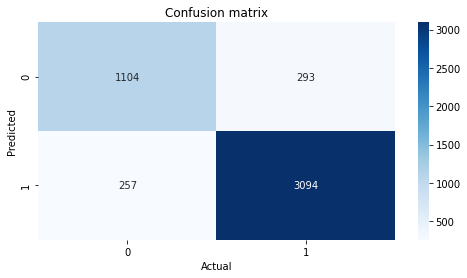

In [104]:
y_pred_rf = rf.predict(X_test)
conf_matrix = confusion_matrix(y_pred_rf, y_test)
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues", 
            fmt="d")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')